In [4]:
from platform import node
from re import S
from tracemalloc import start
from networkx.readwrite.gpickle import read_gpickle
import random
from utility import is_blockable, is_start, report, remove_dead_nodes
import networkx as nx
from patch import topological_generations
import copy
import itertools as it
import numpy as np
import random
import math
from scipy.stats import lognorm, expon, truncnorm

In [527]:
def dynamic_graph_setup(
    fn, seed, start_node_number, blockable_p, double_edge_p, multi_block_p, budget, cross_path_p, graph_sample_monte_carlo, graph_sample_number, no_one_hop
):
    # graph_file_names = [
    #     "r500-dag.gpickle"
    # ]
    graph_file_names = fn + ".gpickle"
    graphs = {}
    graphs[graph_file_names] = read_gpickle("/home/quanghuyngo/Desktop/CFR/Code/honeypot_dynamic/processed_graph/" + graph_file_names)

    CG = graphs[fn + ".gpickle"].copy()
    random.seed(seed)
    CG.graph["budget"] = budget

    
    user_nodes = []
    comp_nodes = []
    # temp = dict()
    for n in CG.nodes():
        if CG.nodes[n]["label"] == "User":
            user_nodes.append(n)
        elif CG.nodes[n]["label"] == "Computer":
            comp_nodes.append(n)
    
    print(CG.graph["DA"])
    user_nodes.append(CG.graph["DA"])
    hassession_to_idx = dict()
    for u in comp_nodes:
        for v in user_nodes:
            # hassession_edges.append((u,v))   
            if CG.has_edge(u, v) == False:
                CG.add_edge(u, v)
                CG.edges[u, v]["label"] = "HasSession"
    
    print("***")
    print(len(user_nodes))
    print(len(comp_nodes))
    
    remove_dead_nodes(CG)
    
    user_nodes = []
    comp_nodes = []
    # temp = dict()
    for n in CG.nodes():
        if CG.nodes[n]["label"] == "User":
            user_nodes.append(n)
        elif CG.nodes[n]["label"] == "Computer":
            comp_nodes.append(n)  
    user_nodes.append(CG.graph["DA"])
    print(len(user_nodes))
    print(len(comp_nodes))
    print("*******")

    
    count = 0
    for u, v in CG.edges():
        if CG.edges[u, v]["label"] == "HasSession":
            hassession_to_idx[(u,v)] = count
            count += 1

    # check random sample if duplicate or not
    temp = set()
    hassession_mask = []
    count = 0
#     print(hassession_to_idx)
    # while count < graph_sample_number:
    #     # print(len(hassession_to_idx))
    #     # print(count)
    #     r = np.random.choice([0, 1], size=len(hassession_to_idx), p=[1./2, 1./2])
    #     if hash(str(list(r))) not in temp:
    #         temp.add(hash(str(list(r))))
    #         hassession_mask.append(r)
    #         count += 1
#     print(user_nodes)
    end_time = 3*24*60*60
    auth_list = generate_temporal_sample_2(CG, user_nodes, comp_nodes, hassession_to_idx, end_time)
    snapshot_list = get_snapshot(auth_list, hassession_to_idx, end_time, hour_per_snapshot = 1)
    
    return auth_list, snapshot_list

In [528]:
def get_snapshot(auth_list, hassession_to_idx, end, hour_per_snapshot = 1):
    current_time = 0
    snapshot_list = []
    while(current_time < end):
        hassession_list = [0 for i in range(len(hassession_to_idx))]
        for i in range(len(auth_list)):
            start_time = auth_list[i][0]
            end_time = auth_list[i][1]
            user = auth_list[i][2]
            comp = auth_list[i][3]
            if current_time > start_time and current_time < end_time:
                hassession_list[hassession_to_idx[(comp, user)]] = 1
        snapshot_list.append(hassession_list)
        current_time += hour_per_snapshot*60*60
    return snapshot_list

In [529]:
def get_online_node(online_edge):
    online_node = []
    for node in online_edge:
        if len(online_edge[node]) != 0:
            online_node.append(node)
    return online_node

In [530]:
def get_frequent_edge_uniform(comp_nodes, frequent_comp, isAdd = True):
    prob = []
    if online_edge == None:
        #set prob for newedge
        for i in range(len(comp_nodes)):
            if isAdd == True:
                if comp_nodes[i] in frequent_comp:
                    prob.append(0)
                else:
                    prob.append(1./(len(comp_node)-len(frequent_comp)))
                return prob
            else:
                if comp_nodes[i] not in frequent_comp:
                    prob.append(0)
                else:
                    prob.append(1./(len(frequent_comp)))
                return prob


In [531]:
def get_new_user_uniform(user_nodes, frequent_edge, online_edge):
    prob = []
    available_user = 0
    for i in range(len(user_nodes)):
        if len(online_edge[user_nodes[i]]) != len(frequent_edge[user_nodes[i]]):
            available_user += 1
        
    for i in range(len(user_nodes)):
        if len(online_edge[user_nodes[i]]) != len(frequent_edge[user_nodes[i]]):
            prob.append(1./available_user)
        else:
            prob.append(0)
    return prob

In [532]:
def get_new_comp_uniform(cur_user, comp_nodes, frequent_edge, online_edge):
    prob = []
    
    frequent_comp = frequent_edge[cur_user]
    online_comp = online_edge[cur_user]
    for i in range(len(comp_nodes)):
        if comp_nodes[i] in frequent_comp and comp_nodes[i] not in online_comp:
            prob.append(1./(len(frequent_comp)-len(online_comp)))
        else: 
            prob.append(0)
    return prob

In [533]:
def set_single_prob_uniform(user_nodes, online_edge):
    online_nodes = get_online_node(online_edge)
    prob = []
    for i in range(len(user_nodes)):
        if user_nodes[i] in online_nodes:
            prob.append(0)
        else:
            prob.append(1./(len(user_nodes) - len(online_nodes)))
    return prob

In [534]:
def set_multi_prob_uniform(user_nodes, online_edge):
    online_nodes = get_online_node(online_edge)
    prob = []
    for i in range(len(user_nodes)):
        if user_nodes[i] not in online_nodes:
            prob.append(0)
        else:
            prob.append(1./(len(online_nodes)))
    return prob

In [535]:
def set_prob_decay(cur_user, comp_nodes, online_edge, edge_node_repeat):
    edge_repeat = edge_node_repeat[cur_user]
    count_list = [None for i in range(len(comp_nodes))]
    count_rep = []
    for i in range(len(comp_nodes)):
        edge = (cur_user, comp_nodes[i])
        if edge not in online_edge:
            count_list[i] = f(edge_repeat[i])
        else:
            count_list[i] = 0
    prob = []
    for i in range(len(count_list)):
        prob.append(count_list[i]/sum(count_list))
    return prob
            

In [536]:
def bimodal_exp_norm_rv(mu_norm, sigma_norm, scale_exp, lower, upper, ratio=0.5):
    X_1 = expon(scale=scale_exp)
    X_2 = truncnorm(
        (lower - mu_norm) / sigma_norm, (upper - mu_norm) / sigma_norm, loc=mu_norm, scale=sigma_norm)
    X = np.concatenate((X_1.rvs(1), X_2.rvs(1)), axis=None)
    rv = np.random.choice(X, size=1, p=[1-ratio, ratio])
    return rv[0]

In [537]:
def bimodal_exp_norm_rv_list(mu_norm, sigma_norm, scale_exp, lower, upper, length, ratio=0.5):
    X_1 = expon(scale=scale_exp)
    X_2 = truncnorm(
        (lower - mu_norm) / sigma_norm, (upper - mu_norm) / sigma_norm, loc=mu_norm, scale=sigma_norm)
    X_1_length = length*0.5
    X_2_length = length*X_1_length
    X = np.concatenate((X_1.rvs(X_1_length), X_2.rvs(X_2_length)), axis=None)
    X = random.shuffle(X)
    return X

In [538]:
def f(x, m = 10000, k = 2, s = 10):
#     if x == 0:
#         return 1000
    func = m/(1+np.exp(k*(x-s)))
    if func < 1:
        func = 1
    return func

In [539]:
# generate edges with interarrival 
# first create a first snap shot of network
# the idea is each node will have 1 primary or frequent edge, this frequent edge will be reconnected
# with a decay probability, i.e, after a while of connecting to a computer, user will "switched" to a new primary
# computer, a user can assumed to have many primary computer, but here, we only assume each will have 1 primary
# User can also have connection to multiple machine at a time (node degree > 1) but with shorter session time and 
# We set this multi edge probability where
# The idea of version 2 is to improve the model interm of additional of new edge. The idea is network will have a 
# set of frequent "edge" which in time will be gradually subtituted by new edges. The new model able us to modify
# the new edge rate of the network by changing new_edge_rate parameter. And by adding new edge to a network, we 
# also remove the frequent edge in the network by the same rate to balance out the number of frequent edge in the
# network.
# 5 parameter: interarrival distribution, session duration distribution, new_edge_rate, multiedge probability
# maximum user node degree. 


def generate_temporal_sample_2(G, user_nodes, comp_nodes, hassession_to_idx, duration):
    # initial snapshot
    session_duration = 4*60*60
    new_edge_rate = 30 # new edge per day 
    # generate interarrival list 
    interarrival_list = []
    cur_primary_edge = dict() # list of previous primary edge mapping to user id
    prev_primary_edge = dict() #list of previous primary edge with starting time
    primary_node_prob = [1./(len(user_nodes)) for i in range(len(user_nodes))]
    
    
    user_id = {user_nodes[i] : i for i in range(len((user_nodes)))}
    comp_id = {comp_nodes[i] : i for i in range(len((comp_nodes)))}
    
    online_edge = {user_nodes[i]: [] for i in range(len(user_nodes))}
    previous_edge = {user_nodes[i]: [] for i in range(len(user_nodes))}
    
    online_node = dict()
    previous_node = {user_nodes[i]: 0 for i in range(len(user_nodes))}
    
    user_to_list = {user_nodes[i]: i for i in range(len(user_nodes))}
    list_to_user = {i: user_nodes[i] for i in range(len(user_nodes))}
    online_auth = []
    edge_node_repeat = {user_nodes[i]: [0 for i in range(len(comp_nodes))] for i in range(len(user_nodes))}
    auth_list = []
    
    hassession_comp = dict()
    for edge in hassession_to_idx:
        user = edge[1] 
        if user not in hassession_comp:
            hassession_comp[user] = []
        hassession_comp[user].append(edge[0])
    
    # initialise a list of "frequent" edge  
    frequent_edge = {user: [] for user in user_nodes}
    frequent_da_edge = {user: [] for user in user_nodes}
    num_session = int(math.ceil(math.log10(len(user_nodes))))
    DA_session = len(G.graph["DA_user"])*num_session
    if DA_session > len(hassession_comp[G.graph["DA"]]):
        DA_session = len(hassession_comp[G.graph["DA"]])
    
    for user in user_nodes:
        if user == G.graph["DA"]:
            for c in random.sample(hassession_comp[user], DA_session):
                frequent_da_edge[user].append(c)
                frequent_edge[user].append(c)
        else:
            for c in random.sample(hassession_comp[user], num_session):
                frequent_edge[user].append(c)

    
    interarrival_list = []
    auth_list = []
    ia_newedge_list = []
    while(sum(ia_newedge_list) < duration):
        interarrival = lognorm.rvs(1.5, scale = (24*60*60)/new_edge_rate,  size=1)
        ia_newedge_list.append(interarrival)
    new_edge_count = 0
    while(sum(interarrival_list) < duration):
        interarrival = lognorm.rvs(1.5, scale = 50,  size=1)
        current_time = float(sum(interarrival_list))
#         current_time = current_time[0]
        print(current_time/(24*60*60))
        mu_norm, sigma_norm = 8, 1.6
        scale_exp = 4
        lower, upper = 0, 100
        session_duration = bimodal_exp_norm_rv(mu_norm, sigma_norm, scale_exp, lower, upper, ratio=0.5)*60*60
        end_time = current_time + session_duration
        interarrival_list.append(interarrival)
        temp = []
        for i in range(len(online_auth)):
            end = online_auth[i][1]
            user = online_auth[i][2]
            comp = online_auth[i][3]
            if end < current_time:
                online_edge[user].remove(comp)
            else:
                temp.append(online_auth[i])
        
        online_auth = temp
        online_nodes = get_online_node(online_edge)
        # primary or multiedge
        
        while (float(sum(ia_newedge_list[:new_edge_count]) > current_time)):
            #choosing new edge
            prob = [1./len(user_nodes) for i in range(len(user_nodes))]
            user = np.random.choice(user_nodes, p = prob)
            frequent_comp = frequent_edge[user]
            # Choose edge to remove   
            prob = get_frequent_edge_uniform(hassession_comp[user], frequent_comp, False)
            rm_comp = np.random.choice(hassession_comp[user], p = prob)
            frequent_edge[user].remove(rm_comp)
            # Cho0se edge too add
            prob = get_frequent_edge_uniform(hassession_comp[user], frequent_comp, True)
            new_comp = np.random.choice(hassession_comp[user], p = prob)
            frequent_edge[user].append(rm_comp)
            new_edge_count += 1
        
        # small tweak to make sure there is enough edge to AD
    
        if len(frequent_edge[G.graph["DA"]]) < len(G.graph["DA_user"]):
            cur_user = G.graph["DA"]
        else:
            prob = get_new_user_uniform(user_nodes, frequent_edge, online_edge)
            cur_user = np.random.choice(user_nodes, p = prob)
        
        prob = get_new_comp_uniform(cur_user, hassession_comp[cur_user], frequent_edge, online_edge)
        cur_comp = np.random.choice(hassession_comp[cur_user], p = prob)
               
        edge = (cur_user, cur_comp)
        online_edge[cur_user].append(cur_comp)
        
        auth_list.append((current_time, end_time, cur_user, cur_comp))
        online_auth.append((current_time, end_time, cur_user, cur_comp))
    return auth_list



In [540]:
args = {
    # "fn": "examplegraph",
    # "fn": "adsim05",
    "fn" : "adsim025_all",
    "budget": 20,
    "start_node_number": -1,
    "blockable_p": 0.8,
    "double_edge_p": 0,
    "multi_block_p": 1,
    "cross_path_p": 0,
    'graph_sample_monte_carlo': 10000,
    "graph_sample_number": 10000,
    "no_one_hop": True,
    "seed": 1
}
auth, snapshot_list = dynamic_graph_setup(**args)

1454
***
1573
101
321
101
*******
0.0
0.0011681894041585034
0.0013709086862156467
0.0036798323784522627
0.003792852714314956
0.0087119437869034
0.00950234080258616
0.009620070120927575
0.009891878613498325
0.0100233898820714
0.011357057100213471
0.011834386564386446
0.012447853065319791
0.012971493037310176
0.013097884825645448
0.013185199254354771
0.013519947813447928
0.013820774446962671
0.013989591826580657
0.01418227512142916
0.02211857494238505
0.02217613409477068
0.023425416413746493
0.023436406594125322
0.023834259456499148
0.025579787646823452
0.026089893856834568
0.026185941677092976
0.026220431306744344
0.026764094503573223
0.026832341433870033
0.031162246499144425
0.03130840630446004
0.03185700277492146
0.032318960484819685
0.03276923129547248
0.037294184432646066
0.04345923182926353
0.04377881700921099
0.05278812996601947
0.05581224827245393
0.056500630176641614
0.057004210475244274
0.05847082438122892
0.0586962078833396
0.05896435332003665
0.05898103871622516
0.05916892693

0.7413634749765585
0.742510341621419
0.7439787770143367
0.7466992377928413
0.7476372034264237
0.7517476615654252
0.7555176675621059
0.7561254981609421
0.7562914386926098
0.7566950679446325
0.7579157441659915
0.7584984099747113
0.7588282265313064
0.7592923887914226
0.7594737109994606
0.760965097324855
0.7612654910659913
0.7613976106114364
0.7626230649071313
0.7659711618917349
0.7669826206590445
0.7675413623233279
0.777457418500752
0.7777866776718744
0.77851504876447
0.7815784626877279
0.7821652219996964
0.7829319598856187
0.7829554409629581
0.7831458769219952
0.7837694898049956
0.784048452819927
0.79008764909427
0.7904886779409445
0.7905824991477985
0.7921890037577602
0.7936165752517153
0.7937988669106094
0.7938965039730448
0.7947575508875945
0.7952431899541874
0.7953266931356673
0.7956173163516729
0.8044363707469866
0.805890846537457
0.8064021913621063
0.8071433474549982
0.807244642127923
0.8079904587567848
0.8080435090191
0.8086135819708818
0.8090693145462252
0.8111512266626375
0.8116

1.647035393495152
1.647379065752291
1.6494376243672761
1.6500986886280933
1.6503763804549323
1.6504094099694309
1.6507742043169387
1.6509177004335995
1.651071730243638
1.651453751610018
1.6531145478261933
1.65654432193791
1.6705205085883614
1.6758965150565017
1.6767033308373294
1.6780857028115732
1.6861941322422098
1.6942304768481171
1.7047799777134598
1.7056589166179967
1.7106464187202295
1.7118328472891722
1.7161215830021364
1.7170396642496144
1.7172306778410675
1.717842433862994
1.734444626856326
1.7348389545457592
1.7348746810446074
1.734884729472774
1.7356503745189353
1.7359617936729066
1.7366241763223333
1.737362670909003
1.7392366630236193
1.7395600921782255
1.7404909158601323
1.742645580350815
1.7435574305106905
1.744102189692143
1.7444353354624236
1.7871589231173197
1.7885344102293945
1.7902947375237324
1.7905580375508412
1.7909629260347308
1.7911383001812842
1.7913245053664577
1.7917109825634256
1.7921351111960915
1.7951494123937364
1.795790317619513
1.7958240166223711
1.7988

2.5604090281395986
2.560476278277098
2.562341231304111
2.5626356907717334
2.564127026733451
2.5646621477143983
2.564994104402528
2.566367565591051
2.566613705344415
2.5675597041016247
2.5676606045727977
2.567671346838122
2.5696746672537043
2.5699649878169604
2.5704137102806945
2.5728380921021925
2.573157156158921
2.5739687733391605
2.5881401080637394
2.5883874841414856
2.591070924235719
2.5924080009430783
2.593810218926527
2.5949512823575267
2.596901618692818
2.6025742780977112
2.603014212218401
2.6030474706200977
2.6037261064813944
2.6060450827034636
2.6069085637497995
2.615029481163953
2.6242212859928644
2.625991740903244
2.626280272302367
2.6267048572284897
2.6267716576482765
2.6277341144466866
2.6294005589429026
2.6299705590352187
2.6305177481878617
2.632621850347031
2.633659673870119
2.6339796109582276
2.6356070856636786
2.635702005201104
2.6422592091688593
2.643165572708947
2.6439080540320123
2.643996548764784
2.6501415285610737
2.653023795311238
2.653451442830581
2.6555538557978

In [347]:
# generate edges with interarrival 
# first create a first snap shot of network
# the idea is each node will have 1 primary or frequent edge, this frequent edge will be reconnected
# with a decay probability, i.e, after a while of connecting to a computer, user will "switched" to a new primary
# computer, a user can assumed to have many primary computer, but here, we only assume each will have 1 primary
# User can also have connection to multiple machine at a time (node degree > 1) but with shorter session time and 
# We set this multi edge probability where 
def generate_temporal_sample(G, user_nodes, comp_nodes, hassession_to_idx, end_time = 50*24*60*60):
    # initial snapshot
    session_duration = 4*60*60
    
    # generate interarrival list 
    interarrival_list = []
    cur_primary_edge = dict() # list of previous primary edge mapping to user id
    prev_primary_edge = dict() #list of previous primary edge with starting time
    
    primary_node_prob = [1./(len(user_nodes)) for i in range(len(user_nodes))]
    
    user_nodes.append(G.graph["DA"])
    user_id = {user_nodes[i] : i for i in range(len((user_nodes)))}
    comp_id = {comp_nodes[i] : i for i in range(len((comp_nodes)))}
    
    online_edge = {user_nodes[i]: [] for i in range(len(user_nodes))}
    previous_edge = {user_nodes[i]: [] for i in range(len(user_nodes))}
    
    online_node = dict()
    previous_node = {user_nodes[i]: 0 for i in range(len(user_nodes))}
    
    user_to_list = {user_nodes[i]: i for i in range(len(user_nodes))}
    list_to_user = {i: user_nodes[i] for i in range(len(user_nodes))}
    online_auth = []
    edge_node_repeat = {user_nodes[i]: [0 for i in range(len(comp_nodes))] for i in range(len(user_nodes))}
    auth_list = []
    while (sum(interarrival_list) < end_time):
        
        interarrival = lognorm.rvs(1.5, scale = 10,  size=1)
        current_time = float(sum(interarrival_list))
#         current_time = current_time[0]
        print(current_time/(24*60*60))
        mu_norm, sigma_norm = 8, 1.6
        scale_exp = 4
        lower, upper = 0, 100
        session_duration = bimodal_exp_norm_rv(mu_norm, sigma_norm, scale_exp, lower, upper, ratio=0.5)*60*60
        end_time = current_time + session_duration
        interarrival_list.append(interarrival)
        temp = []
        for i in range(len(online_auth)):
            end = online_auth[i][1]
            user = online_auth[i][2]
            comp = online_auth[i][3]
            if end < current_time:
                if edge_node_repeat[user][comp_id[comp]] == 0:
                    edge_node_repeat[user][comp_id[comp]] += 1
                    previous_edge[user].append(comp)
                elif f(edge_node_repeat[user][comp_id[comp]]) > 50:
                    edge_node_repeat[user][comp_id[comp]] += 1
                    previous_edge[user].append(comp)
 
                else:
                    edge_node_repeat[user][comp_id[comp]] = 0
                    previous_edge[user].remove(comp)
                online_edge[user].remove(comp)
            else:
                temp.append(online_auth[i])
        
        online_auth = temp
#         print(current_time)
#         print(online_auth)
#         print(len(online_auth))
        
        
        online_nodes = get_online_node(online_edge)
        # primary or multiedge
        if online_nodes == len(user_nodes) :
            multi_prob = 1
        elif len(online_nodes) >10:
            multi_prob = 0.1
        else:
            multi_prob = 0
        
        isMulti = np.random.choice([0, 1], size=1, p=[1-multi_prob, multi_prob])
        if isMulti == 0:
            prob = set_single_prob_uniform(user_nodes, online_edge)
#             print(sum(prob))
            cur_user = np.random.choice(user_nodes, p = prob)
            
            # choose a computer for a node
            if sum(edge_node_repeat[cur_user]) == 0:
                prob = [1./(len(comp_nodes)) for i in range(len(comp_nodes))]
            else:
                prob = set_prob_decay(cur_user, comp_nodes, online_edge, edge_node_repeat)
            cur_comp = np.random.choice(comp_nodes, p = prob)
        else:
            prob = set_multi_prob_uniform(user_nodes, online_edge)
            cur_user = np.random.choice(user_nodes, p = prob)
            if len(edge_node_repeat[cur_user]) == 0:
                prob = [1./(len(comp_nodes)) for i in range(len(comp_nodes))]
            else:
                prob = set_prob_decay(cur_user, comp_nodes, online_edge, edge_node_repeat)
            cur_comp = np.random.choice(comp_nodes, p = prob)
        
        
        edge = (cur_user, cur_comp)
        online_edge[cur_user].append(cur_comp)
        
        auth_list.append((current_time, end_time, cur_user, cur_comp))
        online_auth.append((current_time, end_time, cur_user, cur_comp))
#         print(auth_list)
    return auth_list


In [343]:
auth

[(0.0, 11264.153455060316, 1789, 1521),
 (378.3669616902547, 7426.673993916987, 2619, 1596),
 (385.75123277089637, 20053.853966781546, 2220, 1573),
 (406.9084674359365, 1707.076121681818, 3192, 1579),
 (448.8447544113724, 17636.98702715487, 2845, 1524),
 (459.43918591913945, 32318.418616507686, 3108, 1548),
 (489.4928128296778, 30329.40008162745, 2735, 1562),
 (559.5847071332258, 25990.784494178028, 1936, 1557),
 (671.2525626459484, 30539.43357406135, 2173, 1540),
 (716.2419841553376, 30632.466252963837, 2063, 1529),
 (736.3441357235106, 1218.2025434314542, 1653, 1565),
 (748.0851733350581, 2226.650337916477, 1802, 1556),
 (828.7305776279806, 1215.8972930573168, 3108, 1539),
 (833.6076082064397, 14570.424081707642, 2427, 1602),
 (1256.3609044594252, 1636.6002451055306, 2389, 1583),
 (1325.5383170681002, 21835.17572933743, 2448, 1551),
 (1340.077643547756, 14140.813011079068, 2556, 1544),
 (1355.0351103588343, 4471.316821279021, 2044, 1562),
 (1373.9916634698245, 7850.474843894029, 2190

In [7]:
import pickle
with open('/Users/huyngo/Desktop/Research/honeypot_dynamic/result/score_temporal_adsim025_all_300_50_25_2.pkl', 'rb') as f:
    data = pickle.load(f)

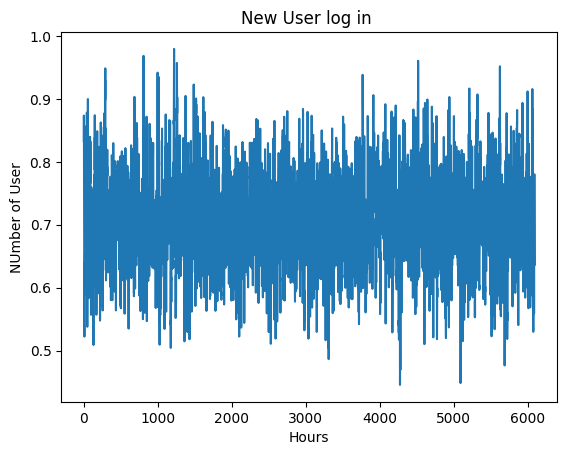

In [8]:
import matplotlib.pyplot as plt
y = [i for i in range(len(data))]
plt.plot(y, data)
plt.title('New User log in ')
plt.xlabel('Hours')
plt.ylabel('NUmber of User')
plt.show()

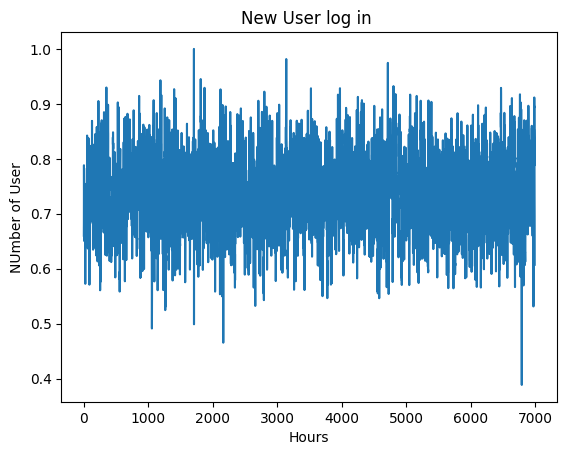

In [10]:
import pickle
with open('/Users/huyngo/Desktop/Research/honeypot_dynamic/result/score_temporal_adsim025_all_300_50_25_1.pkl', 'rb') as f:
    data = pickle.load(f)
import matplotlib.pyplot as plt
y = [i for i in range(len(data))]
plt.plot(y, data)
plt.title('Score overtime')
plt.xlabel('Hours')
plt.ylabel('Score')
plt.show()